In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

from keras.callbacks import ModelCheckpoint
from keras.models import load_model




In [2]:
df = yf.download("AAPL", start="2015-01-01", end="2024-04-04")
company = 'Apple'
df.reset_index(inplace=True)

# Create a new dataframe with relevant features
data = df[['Date','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714724,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716953,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049522,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973557,237458000
...,...,...,...,...,...,...,...
2323,2024-03-27,170.410004,173.600006,170.110001,173.309998,173.075241,60273300
2324,2024-03-28,171.750000,172.229996,170.509995,171.479996,171.247726,65672700
2325,2024-04-01,171.190002,171.250000,169.479996,170.029999,169.799698,46240500
2326,2024-04-02,169.080002,169.339996,168.229996,168.839996,168.611298,49329500


In [4]:
# Check dataset shape
data.shape

(2328, 7)

In [5]:
# Check data types
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


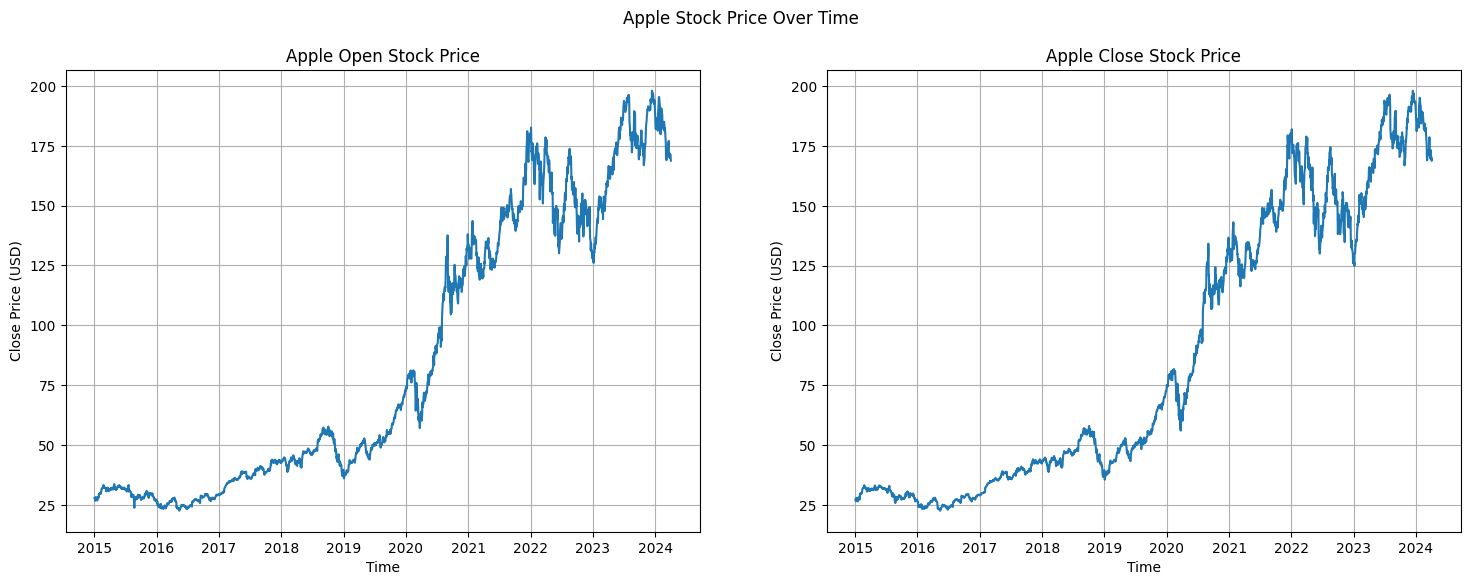

In [7]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Apple Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Apple Close Stock Price")
plt.grid()

plt.suptitle("Apple Stock Price Over Time")
plt.show()

In [8]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= 2019]

# Check filtered data shape
data_5years.shape

(1322, 7)

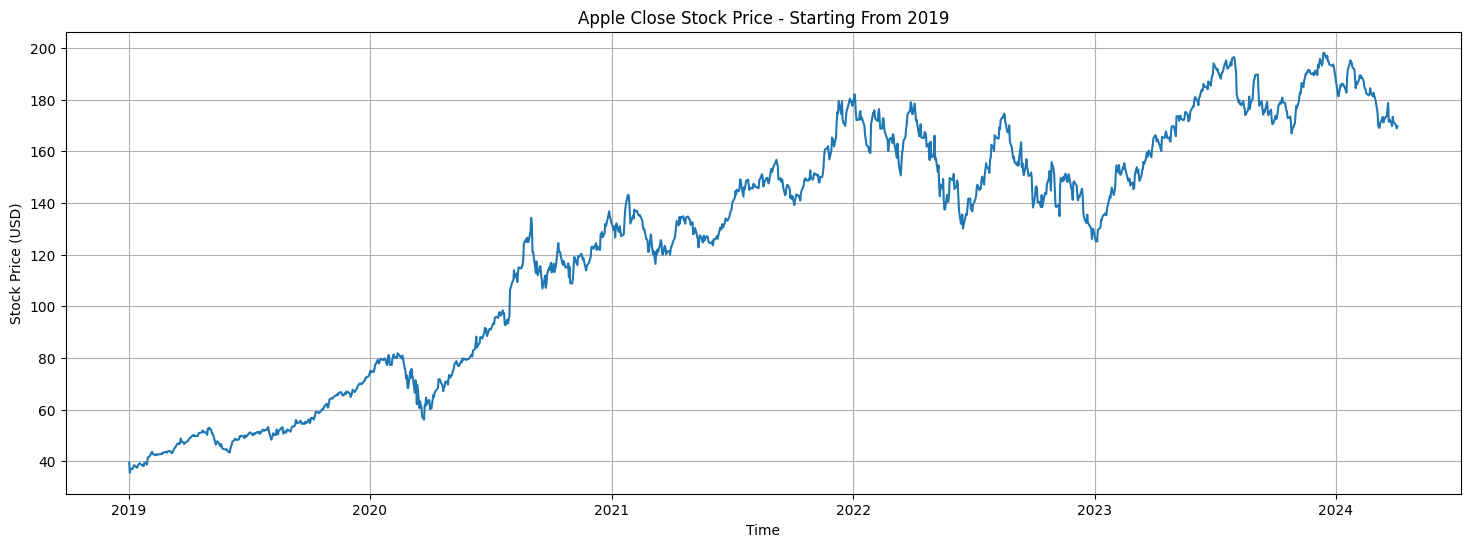

In [9]:
# Plot Close stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data_5years["Date"], data_5years["Close"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Apple Close Stock Price - Starting From 2019")
plt.grid()

In [10]:
# Define selected features and target attribute
features = ["Open", "High", "Low","Close", "Adj Close", "Volume"]
target = "Close"

In [11]:
# Define start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Split dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [12]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (2138, 6)
Validation Set: (126, 6)
Testing Set: (41, 6)


In [13]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
        Open       High        Low      Close  Adj Close     Volume
0  27.847500  27.860001  26.837500  27.332500  24.402172  212818400
1  27.072500  27.162500  26.352501  26.562500  23.714724  257142000
2  26.635000  26.857500  26.157499  26.565001  23.716953  263188400
3  26.799999  27.049999  26.674999  26.937500  24.049522  160423600
4  27.307501  28.037500  27.174999  27.972500  24.973557  237458000
Validation Dataset:
            Open        High         Low       Close   Adj Close    Volume
2138  193.779999  193.880005  191.759995  192.460007  191.443298  31458200
2139  191.570007  192.979996  190.619995  191.330002  190.319275  46920300
2140  189.839996  192.020004  189.199997  191.809998  190.796738  45094300
2141  191.410004  192.669998  190.240005  190.679993  189.672684  46778000
2142  189.259995  189.990005  187.039993  188.610001  187.613632  59922200
Testing Dataset:
            Open        High         Low       Close   Adj Close    Volume
2264  187.14

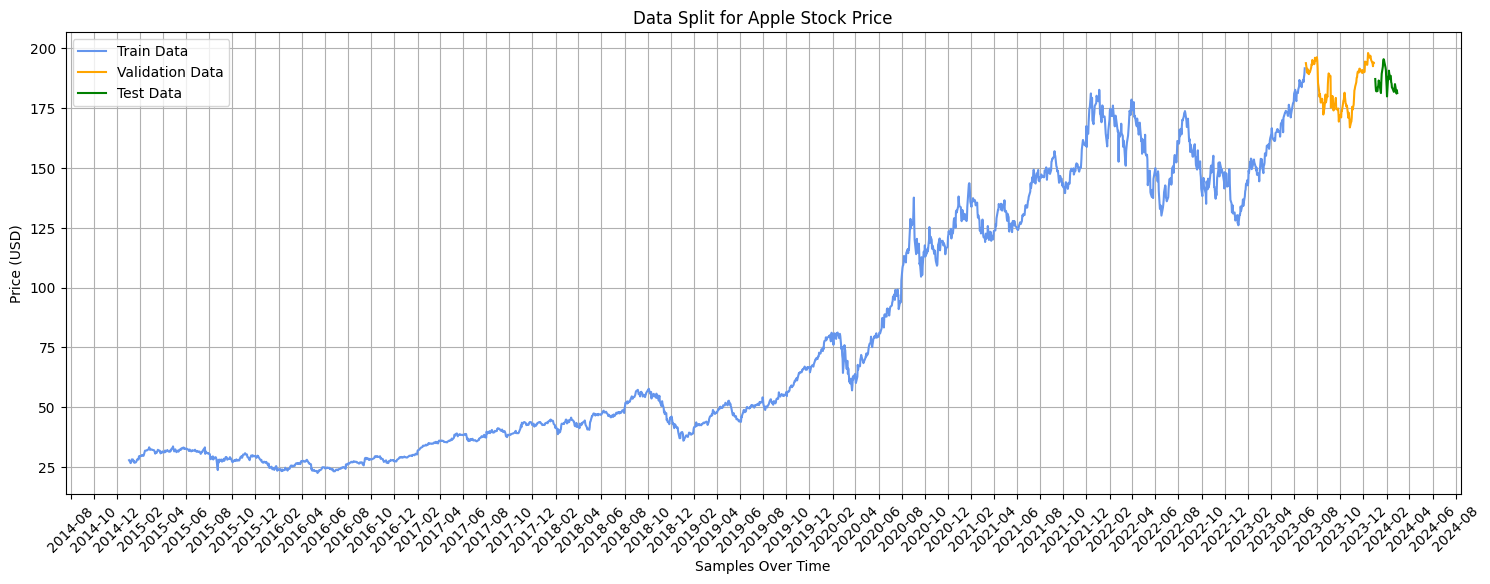

In [14]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Apple Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

In [15]:
# Check the distribution of input features
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2.328000e+03
mean,86.630273,87.563635,85.747739,86.699326,84.668054,1.220443e+08
std,57.464462,58.084345,56.881077,57.514983,57.912044,6.808322e+07
min,22.500000,22.917500,22.367500,22.584999,20.744013,2.404830e+07
25%,35.931874,36.125000,35.771876,35.923749,33.536314,7.631758e+07
50%,55.209999,55.728750,54.422499,55.222502,52.993181,1.045086e+08
75%,144.380005,146.670002,143.027496,145.324997,143.206776,1.462802e+08
max,198.020004,199.619995,197.000000,198.110001,197.589523,6.488252e+08


In [16]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

In [17]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [18]:
# Check loaded datasets shape
data_train_df = data_train_scaled_final
data_validate_df = data_validate_scaled_final
data_test_df = data_test_scaled_final
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (2138, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [19]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume       Date
0  0.031618  0.028809  0.026467  0.027701   0.021244  0.289462 2015-01-02
1  0.027035  0.024743  0.023595  0.023208   0.017251  0.361694 2015-01-05
2  0.024449  0.022965  0.022440  0.023223   0.017264  0.371548 2015-01-06
3  0.025424  0.024087  0.025504  0.025396   0.019196  0.204077 2015-01-07
4  0.028425  0.029843  0.028465  0.031435   0.024562  0.329616 2015-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume       Date
0  1.012712  0.996503  1.002960  0.991189   0.991278 -0.006091 2023-07-03
1  0.999645  0.991257  0.996211  0.984596   0.984750  0.019107 2023-07-05
2  0.989416  0.985661  0.987803  0.987397   0.987523  0.016131 2023-07-06
3  0.998699  0.989450  0.993961  0.980803   0.980995  0.018875 2023-07-07
4  0.985987  0.973829  0.975014  0.968725   0.969038  0.040295 2023-07-10
Testing Dataset:
       Open      High       Low     Close  Adj Close    V

In [20]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [21]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [22]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [23]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).

    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.

    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [24]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [25]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [26]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (2305, 6)

 Data Train Scaled: (2138, 6)
> Data Train X: (2078, 60, 6)
> Data Train y: (2078,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


In [27]:
# Initializing the model
regressor = Sequential()

In [28]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [29]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [30]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [31]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [32]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [33]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [34]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [35]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "..//models//"
model_name = "google_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

In [36]:
# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=10,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - loss: 0.0557 - val_loss: 0.0217
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 378ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 419ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 361ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - loss: 0.0019 - val_loss: 0.0025


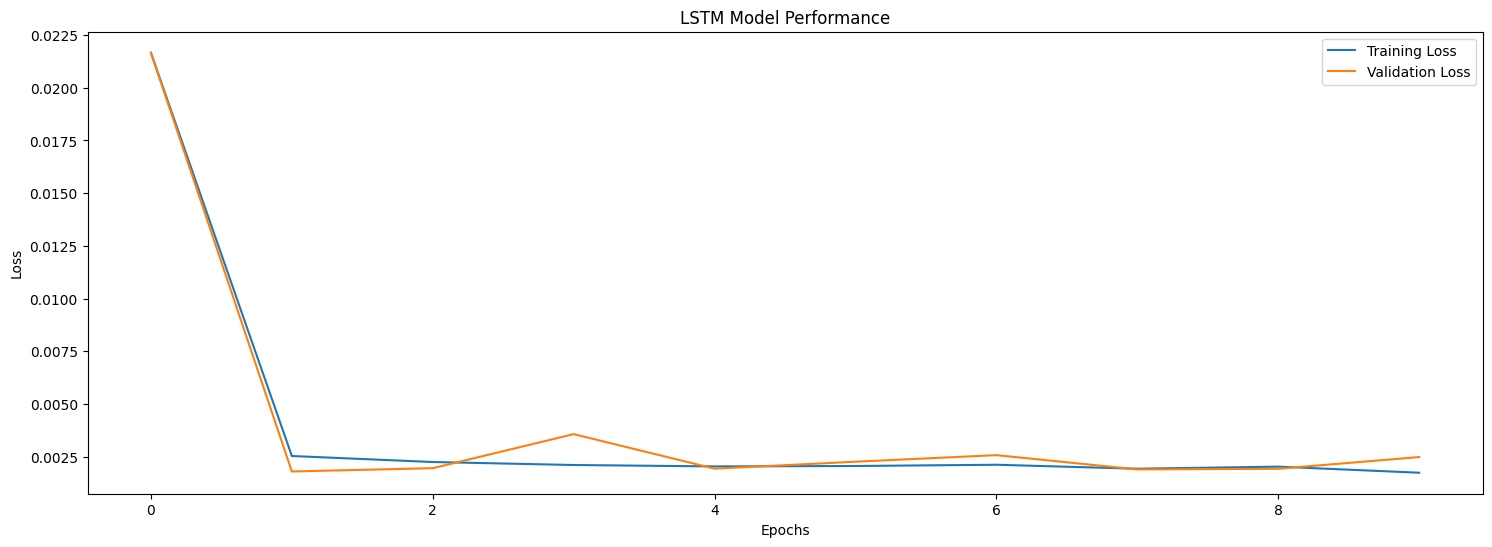

In [37]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
# Prepare model location and name
model_location = "..//models//"
model_name = "google_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

In [39]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [40]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

In [41]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

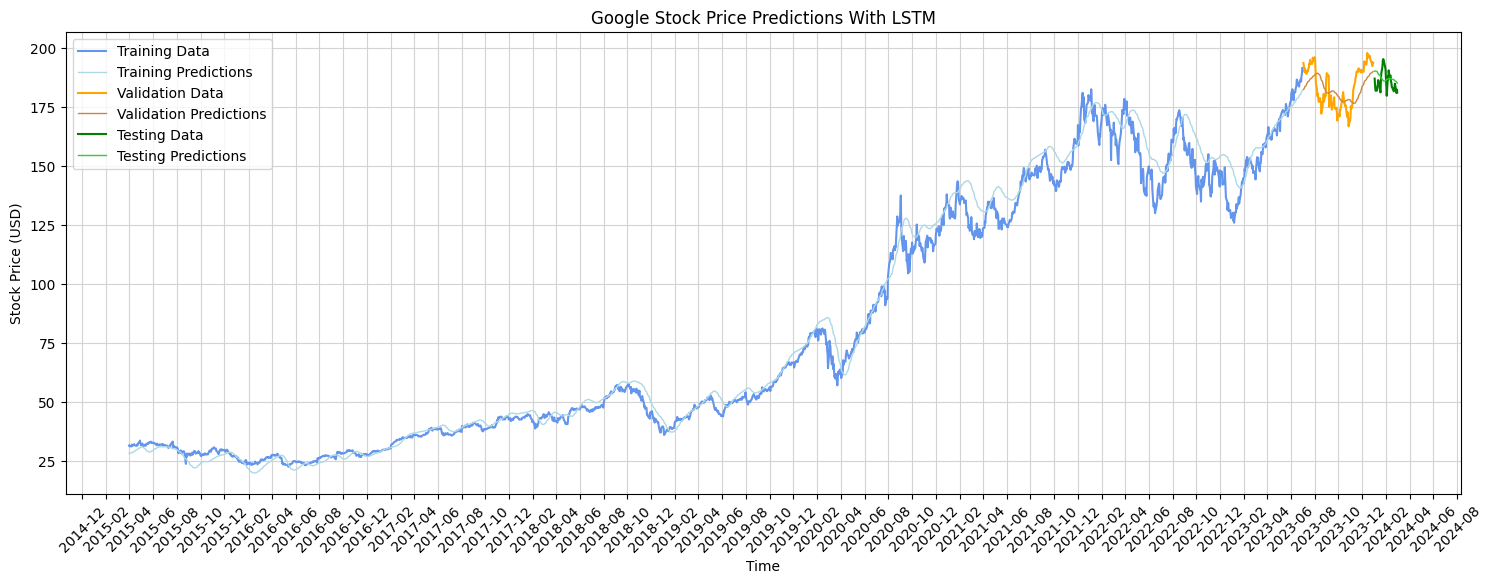

In [42]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")